In [1]:
import os
os.chdir("../")

In [2]:
DATA_DIR = "./data/raw/BCI_Comp_III_Wads_2004/"

In [3]:
from src.data import preprocessing,extract_data
from src.models import model
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
np.random.seed(42)

# Subject A

## Let's read in our data

In [5]:
seconds_to_slice = 0.65
FS = 240
num_electrodes = 64

In [6]:
os.getcwd()

'E:\\Project_Oracle\\EEG\\bci_iii_p300'

In [7]:
A_train = extract_data.extract_data(DATA_DIR+"Subject_A_Train.mat",seconds_to_slice)
A_test = extract_data.extract_data(DATA_DIR+"Subject_A_Test.mat",seconds_to_slice)
print(A_train.keys())
print(A_test.keys())

dict_keys(['code', 'signal', 'label', 'targetchar'])
dict_keys(['code', 'signal'])


In [8]:
print(A_train['signal'].shape)
print(A_test['signal'].shape)
print(A_train['code'].shape)
print(A_test['code'].shape)
print(A_train['label'].shape)
print(A_train['targetchar'].shape)

(85, 15, 12, 64, 156)
(100, 15, 12, 64, 156)
(85, 15, 12)
(100, 15, 12)
(85, 15, 12)
(1,)


In [9]:
A_train['targetchar'][0]

'EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI'

## Input Normalization

### Subsample

In [10]:
A_train['signal'] = preprocessing.subsample(A_train['signal'],2)
A_test['signal'] = preprocessing.subsample(A_test['signal'],2)
print(A_train['signal'].shape)
print(A_test['signal'].shape)

(85, 15, 12, 64, 78)
(100, 15, 12, 64, 78)


### Bandpass filter

In [11]:
# After subsampling,the frequency is equivalent to FS/2

A_train['signal'] = preprocessing.butter_bandpass_filter(A_train['signal'],lowcut = 0.1,highcut = 20,
                                                         fs = int(FS/2),order = 5,axis = -1)
A_test['signal'] = preprocessing.butter_bandpass_filter(A_test['signal'],lowcut = 0.1,highcut = 20,
                                                         fs = int(FS/2),order = 5,axis = -1)

In [12]:
print(A_train['signal'].shape)
print(A_test['signal'].shape)

(85, 15, 12, 64, 78)
(100, 15, 12, 64, 78)


### Normalize on channel

In [13]:
A_train_mean = A_train['signal'].mean(axis = -1,keepdims = True)
A_train_std = A_train['signal'].std(axis = -1,keepdims = True)
A_test_mean = A_test['signal'].mean(axis = -1,keepdims = True)
A_test_std = A_test['signal'].std(axis = -1,keepdims = True)
print(A_train_mean.shape)
print(A_train_std.shape)
print(A_test_mean.shape)
print(A_test_std.shape)

(85, 15, 12, 64, 1)
(85, 15, 12, 64, 1)
(100, 15, 12, 64, 1)
(100, 15, 12, 64, 1)


In [14]:
A_train['signal'] = (A_train['signal']-A_train_mean)/A_train_std
A_test['signal']  = (A_test['signal']-A_test_mean)/A_test_std

## Do some visualization to get familiar with P300

In [15]:
sig_vis = A_train['signal'][3,2]
code_vis = A_train['code'][3,2]
label_vis = A_train['label'][3,2]

In [16]:
print(code_vis)
print(label_vis)

[  2.   7.   9.   4.   3.   6.   5.  10.   8.  12.  11.   1.]
[ 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]


It should be a V

In [17]:
print(A_train['targetchar'][0][3])

V


### A positive sample

Our data has 78 points which represents 0.65s so we have to draw a vertical line at:

78 / 0.65 * 0.3 = 36

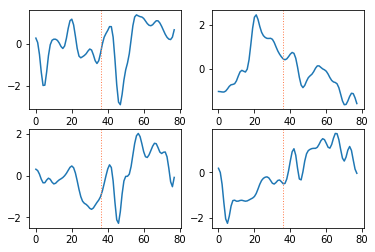

In [18]:
from src.visualization import visualize
visualize.electrodes_selected_visualize(sig_vis[3],elec_to_vis = [10,20,30,40],n_rows = 2,x_vline = 36)

It really doesn't make sense to read P300 directly from single trial...You can't really tell whether a peak near 300 is P300

### A negative sample

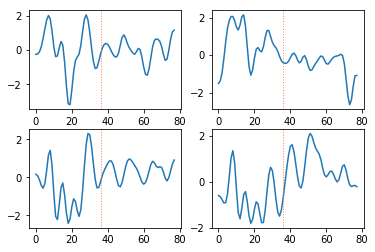

In [19]:
visualize.electrodes_selected_visualize(sig_vis[10],elec_to_vis = [10,20,30,40],n_rows = 2,x_vline = 36)

Well let's just forget about visualizing and keep going.

## Build our model

In [22]:
from keras import layers, models
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf


# In the original paper they use a custom activation function for
# the first two layers




# model.add(Activation(custom_activation))

def CNN_1_P300_PAMI_BCIIII(Ns=10, seconds_to_slice=0.65):
    """ Reference: Convolutional Neural Networks for P300 Detection with Application to Brain-Computer Interfaces

    return an uncompiled model

    """
    # Let's define the custom activation function used in this layer first
    def sigmoid_pami_p300(x):
        return 1.7159 * K.tanh(2 * x / 3)

    get_custom_objects().update({'custom_activation': layers.Activation(sigmoid_pami_p300)})
    
    # Then we build the model
    num_electrodes = 64
    Fs = 120  # Original Fs is 240Hz but in this paper they have subsampled
    points_to_slice = int(Fs * seconds_to_slice)
    input_layer = layers.Input([num_electrodes, points_to_slice,1])
    conv_1 = layers.convolutional.Conv2D(filters=Ns, kernel_size=[num_electrodes, 1], strides=[1, 1],
                                         activation='linear')(input_layer)
    
    conv_1_acti = layers.Activation(sigmoid_pami_p300)(conv_1)
    # It's slightly different in the paper though..(filter have same parameter along the same axis)but I decide to use this more modern choice
    conv_2 = layers.convolutional.Conv2D(filters=5 * Ns, kernel_size=[1, 13], strides=[1, 13],
                                         activation='linear')(conv_1_acti)
    conv_2_acti = layers.Activation(sigmoid_pami_p300)(conv_2)
    flatten = layers.Flatten()(conv_2_acti)
    fc = layers.Dense(100,activation='sigmoid')(flatten)
    output_layer = layers.Dense(2,activation='sigmoid')(fc)

    model = models.Model(inputs = input_layer,outputs=output_layer)

    return model

In [23]:
model_cnn1 = CNN_1_P300_PAMI_BCIIII(Ns = 10,seconds_to_slice = seconds_to_slice)

In [24]:
model_cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 78, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 78, 10)         650       
_________________________________________________________________
activation_6 (Activation)    (None, 1, 78, 10)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 6, 50)          6550      
_________________________________________________________________
activation_7 (Activation)    (None, 1, 6, 50)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
__________

It seems like the original paper's conv2 has same parameters along the channel axis but I'll go with the modern architecture which is Conv2D.

In [25]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_mse',patience = 10)  # val_mse is invalid

model_cnn1.compile(optimizer='sgd',loss = 'binary_crossentropy',metrics = ['acc'])

In [26]:
print(A_train['signal'].shape)
print(A_train['label'].shape)

(85, 15, 12, 64, 78)
(85, 15, 12)


In [27]:
A_train['signal'] = A_train['signal'].reshape([-1,64,78])
A_train['label'] = A_train['label'].reshape([-1,])

In [28]:
A_train['signal'] = np.expand_dims(A_train['signal'],-1)

In [29]:
print(A_train['signal'].shape)
print(A_train['label'].shape)

(15300, 64, 78, 1)
(15300,)


In [30]:
A_train['label'][0:12]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.])

In [31]:
from keras.utils import to_categorical
A_train['label'] = to_categorical(A_train['label'],2)
print(A_train['label'].shape)

(15300, 2)


In [46]:
model_cnn1.fit(A_train['signal'],A_train['label'],batch_size=64,epochs=100,callbacks=[earlystopping],validation_split=0.05)

Train on 14535 samples, validate on 765 samples
Epoch 1/100
14336/14535 [============================>.] - ETA: 0s - loss: 0.4588 - acc: 0.8328

D:\Anaconda3\lib\site-packages\keras\callbacks.py:494: RuntimeWarning: Early stopping requires val_mse available!
  (self.monitor), RuntimeWarning)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [43]:
earlystopping = EarlyStopping(monitor = 'val_acc',patience = 10)  # val_mse is invalid

I want to custome some metrics.

## Custom metrics in Keras

In [44]:
def true_positive(y_true,y_pred):
    cmx = tf.confusion_matrix(K.argmax(y_true, axis = 1), K.argmax(y_pred, axis = 1))
    return tf.gather_nd(cmx, [[0,0]])

model_cnn1.compile(optimizer='sgd',loss = 'binary_crossentropy',metrics = ['acc',true_positive])

In [45]:
model_cnn1.fit(A_train['signal'],A_train['label'],batch_size=64,epochs=100,callbacks=[earlystopping],validation_split=0.05)

Train on 14535 samples, validate on 765 samples
Epoch 1/100
14535/14535 [==============================] - 3s - loss: 0.4338 - acc: 0.8333 - true_positive: 53.3037 - val_loss: 0.4223 - val_acc: 0.8340 - val_true_positive: 53.1752
Epoch 2/100
14535/14535 [==============================] - 2s - loss: 0.4296 - acc: 0.8333 - true_positive: 53.3076 - val_loss: 0.4168 - val_acc: 0.8340 - val_true_positive: 53.1752
Epoch 3/100
14535/14535 [==============================] - 2s - loss: 0.4255 - acc: 0.8333 - true_positive: 53.3154 - val_loss: 0.4124 - val_acc: 0.8340 - val_true_positive: 53.1752
Epoch 4/100
14535/14535 [==============================] - 2s - loss: 0.4212 - acc: 0.8333 - true_positive: 53.3076 - val_loss: 0.4074 - val_acc: 0.8340 - val_true_positive: 53.1752
Epoch 5/100
14535/14535 [==============================] - 2s - loss: 0.4169 - acc: 0.8333 - true_positive: 53.3037 - val_loss: 0.4034 - val_acc: 0.8340 - val_true_positive: 53.1752
Epoch 6/100
14535/14535 [=================

Clearly true_positive as a metric is not we want.

In [49]:
model_cnn1.compile(optimizer='sgd',loss = 'binary_crossentropy',metrics = ['acc'])

In [50]:
earlystopping = EarlyStopping(monitor = 'val_loss',patience = 10)

In [51]:
model_cnn1.fit(A_train['signal'],A_train['label'],batch_size=64,epochs=100,callbacks=[earlystopping],validation_split=0.05)

Train on 14535 samples, validate on 765 samples
Epoch 1/100
14535/14535 [==============================] - 3s - loss: 0.4305 - acc: 0.8333 - val_loss: 0.4159 - val_acc: 0.8340
Epoch 2/100
14535/14535 [==============================] - 2s - loss: 0.4269 - acc: 0.8333 - val_loss: 0.4122 - val_acc: 0.8340
Epoch 3/100
14535/14535 [==============================] - 2s - loss: 0.4230 - acc: 0.8333 - val_loss: 0.4073 - val_acc: 0.8340
Epoch 4/100
14535/14535 [==============================] - 2s - loss: 0.4186 - acc: 0.8333 - val_loss: 0.4029 - val_acc: 0.8340
Epoch 5/100
14535/14535 [==============================] - 2s - loss: 0.4145 - acc: 0.8333 - val_loss: 0.3987 - val_acc: 0.8340
Epoch 6/100
14535/14535 [==============================] - 2s - loss: 0.4103 - acc: 0.8333 - val_loss: 0.3949 - val_acc: 0.8333
Epoch 7/100
14535/14535 [==============================] - 2s - loss: 0.4066 - acc: 0.8338 - val_loss: 0.3911 - val_acc: 0.8327
Epoch 8/100
14535/14535 [==============================]